In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

card_df = pd.read_csv('./train_creditcard.csv')
card_df.head()

# Amount는 트랜잭션 금액 Class 는 레이블


from sklearn.model_selection import train_test_split

# 인자로 입력받은 DF을 복사한 뒤, Time칼럼만 삭제하고 복사된 DF반환

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace = True)
    return df_copy

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('학습 데이터의 레이블 값 비율')
print(y_train.value_counts()/y_train.shape[0]*100)
print('\n')
print('테스트 데이터의 레이블 값 비율')
print(y_test.value_counts()/y_test.shape[0]*100)
print('\n')

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 {0:.4f}, 정밀도 {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall,f1, roc_auc))


get_clf_eval(y_test, lr_pred, lr_pred_proba)


# 학습/테스트 데이터를 입력받아 학습/예측/평가 수행하는 함수

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)
    
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators = 1000, num_leaves=64, n_jobs=1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test = X_test, tgt_train = y_train, tgt_test = y_test)


학습 데이터의 레이블 값 비율
0    99.827451
1     0.172549
Name: Class, dtype: float64


테스트 데이터의 레이블 값 비율
0    99.826785
1     0.173215
Name: Class, dtype: float64


오차 행렬
[[85282    13]
 [   57    91]]
정확도 0.9992, 정밀도 0.8750, 재현율 : 0.6149, F1 : 0.7222, AUC : 0.9570
오차 행렬
[[85289     6]
 [   36   112]]
정확도 0.9995, 정밀도 0.9492, 재현율 : 0.7568, F1 : 0.8421, AUC : 0.9797


In [17]:
import seaborn as sns
# plt.figure(figsize=(8,4))
# plt.xticks(range(0,30000,1000),rotation=60)
# sns.distplot(card_df['Amount'])

from sklearn.preprocessing import StandardScaler

# 정규분포를 따르게 하는 함수

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train= y_train, tgt_test = y_test)

print('###LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train, ftr_test = X_test, tgt_train= y_train, tgt_test = y_test)
print('\n')

# 정규분포 형태로 변환했을 때도 성능이 개선되지 않은것을 볼 수 있다.



# log 변환 함수

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    return df_copy

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('###로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train= y_train, tgt_test = y_test)

print('###LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1,boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train, ftr_test = X_test, tgt_train= y_train, tgt_test = y_test)

# 두 모델 모두 성능의 개선을 확이할 수 있다.


###로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도 0.9992, 정밀도 0.8654, 재현율 : 0.6081, F1 : 0.7143, AUC : 0.9702
###LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도 0.9995, 정밀도 0.9492, 재현율 : 0.7568, F1 : 0.8421, AUC : 0.9773


###로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도 0.9992, 정밀도 0.8812, 재현율 : 0.6014, F1 : 0.7149, AUC : 0.9727
###LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도 0.9995, 정밀도 0.9576, 재현율 : 0.7635, F1 : 0.8496, AUC : 0.9786


In [33]:
import seaborn as sns

# plt.figure(figsize=(9,9))
# corr = card_df.corr()
# sns.heatmap(corr,cmap='RdBu')

# 이상치 탐색 

import numpy as np

def get_outlier(df=None, column=None, weight = 1.5):
    fraud = df[df['Class']== 1][column]
    quantile_25 = np.percentile(fraud.values,25)
    quantile_75 = np.percentile(fraud.values,75)
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr*weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

# outlier_index = get_outlier(df=card_df, column='V14', weight = 1.5)
# print('이상치 데이터 인덱스 : ', outlier_index)

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    outlier_index = get_outlier(df=df_copy, column='V14', weight = 1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy


X_train, X_test, y_trian, y_test = get_train_test_dataset(card_df)
print('###로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test = X_test, tgt_train= y_train, tgt_test = y_test)

print('###LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf,ftr_train=X_train, ftr_test = X_test, tgt_train= y_train, tgt_test = y_test)

###로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도 0.9993, 정밀도 0.8750, 재현율 : 0.6712, F1 : 0.7597, AUC : 0.9743
###LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도 0.9997, 정밀도 0.9680, 재현율 : 0.8288, F1 : 0.8930, AUC : 0.9831


SMOTE 적용전 학습용 피처/레이블 데이터 세트 :  (199364, 29) (199364,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE 적용 후 레이블 값 분포 : 
 0    199020
1       344
Name: Class, dtype: int64




C:\Users\jiyun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


오차 행렬
[[83939  1356]
 [   16   132]]
정확도 0.9839, 정밀도 0.0887, 재현율 : 0.8919, F1 : 0.1614, AUC : 0.9810


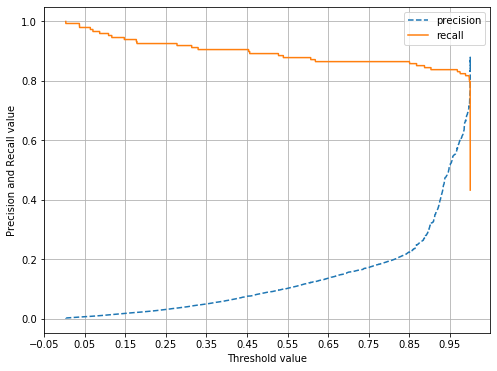

In [ ]:
# SMOTE 오버 샘플링
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.linear_model import LogisticRegression

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace = True)
    return df_copy

def get_train_test_dataset(df=None):
    df_copy = get_preprocessed_df(df)
    X_features = df_copy.iloc[:,:-1]
    y_target = df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test


card_df = pd.read_csv('./train_creditcard.csv')

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_sample(X_train, y_train)
print('SMOTE 적용전 학습용 피처/레이블 데이터 세트 : ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포 : \n' , pd.Series(y_train).value_counts())
print('\n')

def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 {0:.4f}, 정밀도 {1:.4f}, 재현율 : {2:.4f}, F1 : {3:.4f}, AUC : {4:.4f}'.format(accuracy, precision, recall,f1, roc_auc))

def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)



lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train_over, ftr_test = X_test, tgt_train= y_train_over, tgt_test = y_test)

# 재현율이 89%이지만, 정밀도는 8% 폭락하였다. 쓸 수 없는 분류
# 지나치게 Class=1로 적용해 정밀도가 떨어진 것.

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize =(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], ls = '--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start,end,0.1),2))
    
    plt.xlabel('Threshold value')
    plt.ylabel('Precision and Recall value')
    plt.legend()
    plt.grid()
    plt.show()


precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])    
    
# 임계값 0.99를 기준으로 차이가 너무 심함 (임계값의 민감도가 크다.)

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves = 64, n_jobs = 1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test = X_test, tgt_train= y_train_over, tgt_test = y_test)

# 일반적으로 SMOTE를 적용하면 정밀도가 낮아지는 것이 일반적이다.


    